In [71]:
import json
import requests
from requests.exceptions import HTTPError, ConnectionError, Timeout, RequestException
#add Path
from pathlib import Path
from datetime import datetime
import time
import random
import logging
import os
from urllib.parse import urlparse

import base64
from getpass import getpass

from IPython.display import Image, display, FileLink,IFrame
import instructor
from pydantic import BaseModel
from openai import OpenAI

import pdfplumber

https://cdn.mcdonalds.pl/uploads/20250910144011/352978-tabela-wo-8-11-2023-mop.pdf?openOutsideMcd=true

# APEN AI KEY

In [87]:
openai_key = getpass("Wprowadź swój klucz OpenAI: ")

In [88]:
openai_client = OpenAI(api_key=openai_key)

In [74]:
raw_pdf_PATH = Path("./pdf")
raw_pdf_PATH.mkdir(parents=True, exist_ok=True)
print(raw_pdf_PATH.exists())

True


# Logs

In [75]:
os.makedirs("logs", exist_ok=True)
LOGS_PATH = Path("logs")
LOGS_FILE = LOGS_PATH / 'logs.log'
print(LOGS_PATH.exists())

True


# IMG

In [96]:
os.makedirs("receipt", exist_ok=True)
receipt_PATH = Path("receipt")
print(receipt_PATH.exists())

True


In [77]:
logging.basicConfig(
    filename=str(LOGS_FILE),  # will create the logs folder (if it doesn't exist) and the errors.log file | str ensures compatibility with older Python
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

logger = logging.getLogger(__name__)

In [78]:
# for all_pdf in pdf_PATH.glob('*.pdf'):
    # print(all_pdf) _to_create_text
pdf_path_to_create_text = raw_pdf_PATH/'mcd_nutritional_table-time-2025-09-19_01-21-08.pdf'
display(FileLink(pdf_path_to_create_text))

d:\DataSince\m_cla\pdf\mcd_nutritional_table-time-2025-09-19_01-21-08.pdf

# JSON

In [121]:
os.makedirs('json_calories_table', exist_ok=True)
json_calories_table_PATH = Path('json_calories_table')
print(json_calories_table_PATH.exists())

True


# Pobranie PFD

## Pobieranie nazywy do przyszłego analizowania i ewentualnego pobrania nowego pdf w razie zmiany tabeli?

In [79]:
url = "https://cdn.mcdonalds.pl/uploads/20250910144011/352978-tabela-wo-8-11-2023-mop.pdf"

parsed_url = urlparse(url)
filename = os.path.basename(parsed_url.path)  # wyciągnie "352978-tabela-wo-8-11-2023-mop.pdf"

print(filename)

352978-tabela-wo-8-11-2023-mop.pdf


In [80]:
BASE_URL = 'https://cdn.mcdonalds.pl/uploads/20250910144011/352978-tabela-wo-8-11-2023-mop.pdf'

def scrape_pdf(url):
    try:
        url = BASE_URL
        response = requests.get(
            url,
            # params=params,
            headers={"version":"2"},

            #timeout for 5 sek
            timeout=5
        )


        response.raise_for_status()

        # timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        pdf_name=filename

        with open(raw_pdf_PATH/pdf_name, 'wb') as f:
            f.write(response.content)
        logger.info(f'💚 udało się pobrać plik pfd {pdf_name}')
    except HTTPError as e:
        if 400 <= response.status_code < 500:
            logger.error(f'❌Błąd klienta {response.status_code}:{response.reason} dla strony..')
            return
        elif 500 <= response.status_code < 600:
            logger.warning(f'⚠️Błąd serwera {response.status_code}:{response.reason}')
        else:
            reason = getattr(response, 'reason', "brak opisu")
            logger.error(f'❌ Inny błąt HTTP {response.status_code}:{reason}')

    except (ConnectionAbortedError, Timeout) as e:
        logger.warning(f'🌐 Problem z połączeniem/timeout na stronie: {e}')
    
    except OSError as e:
        logger.error(f'❓ Niespodziewany wyjątek przy stronie, {e.__class__.__name__}: {e}')

    else:
    
        return None

In [81]:
scrape_pdf(BASE_URL)

# Zamiana img paragonów na bajty

''
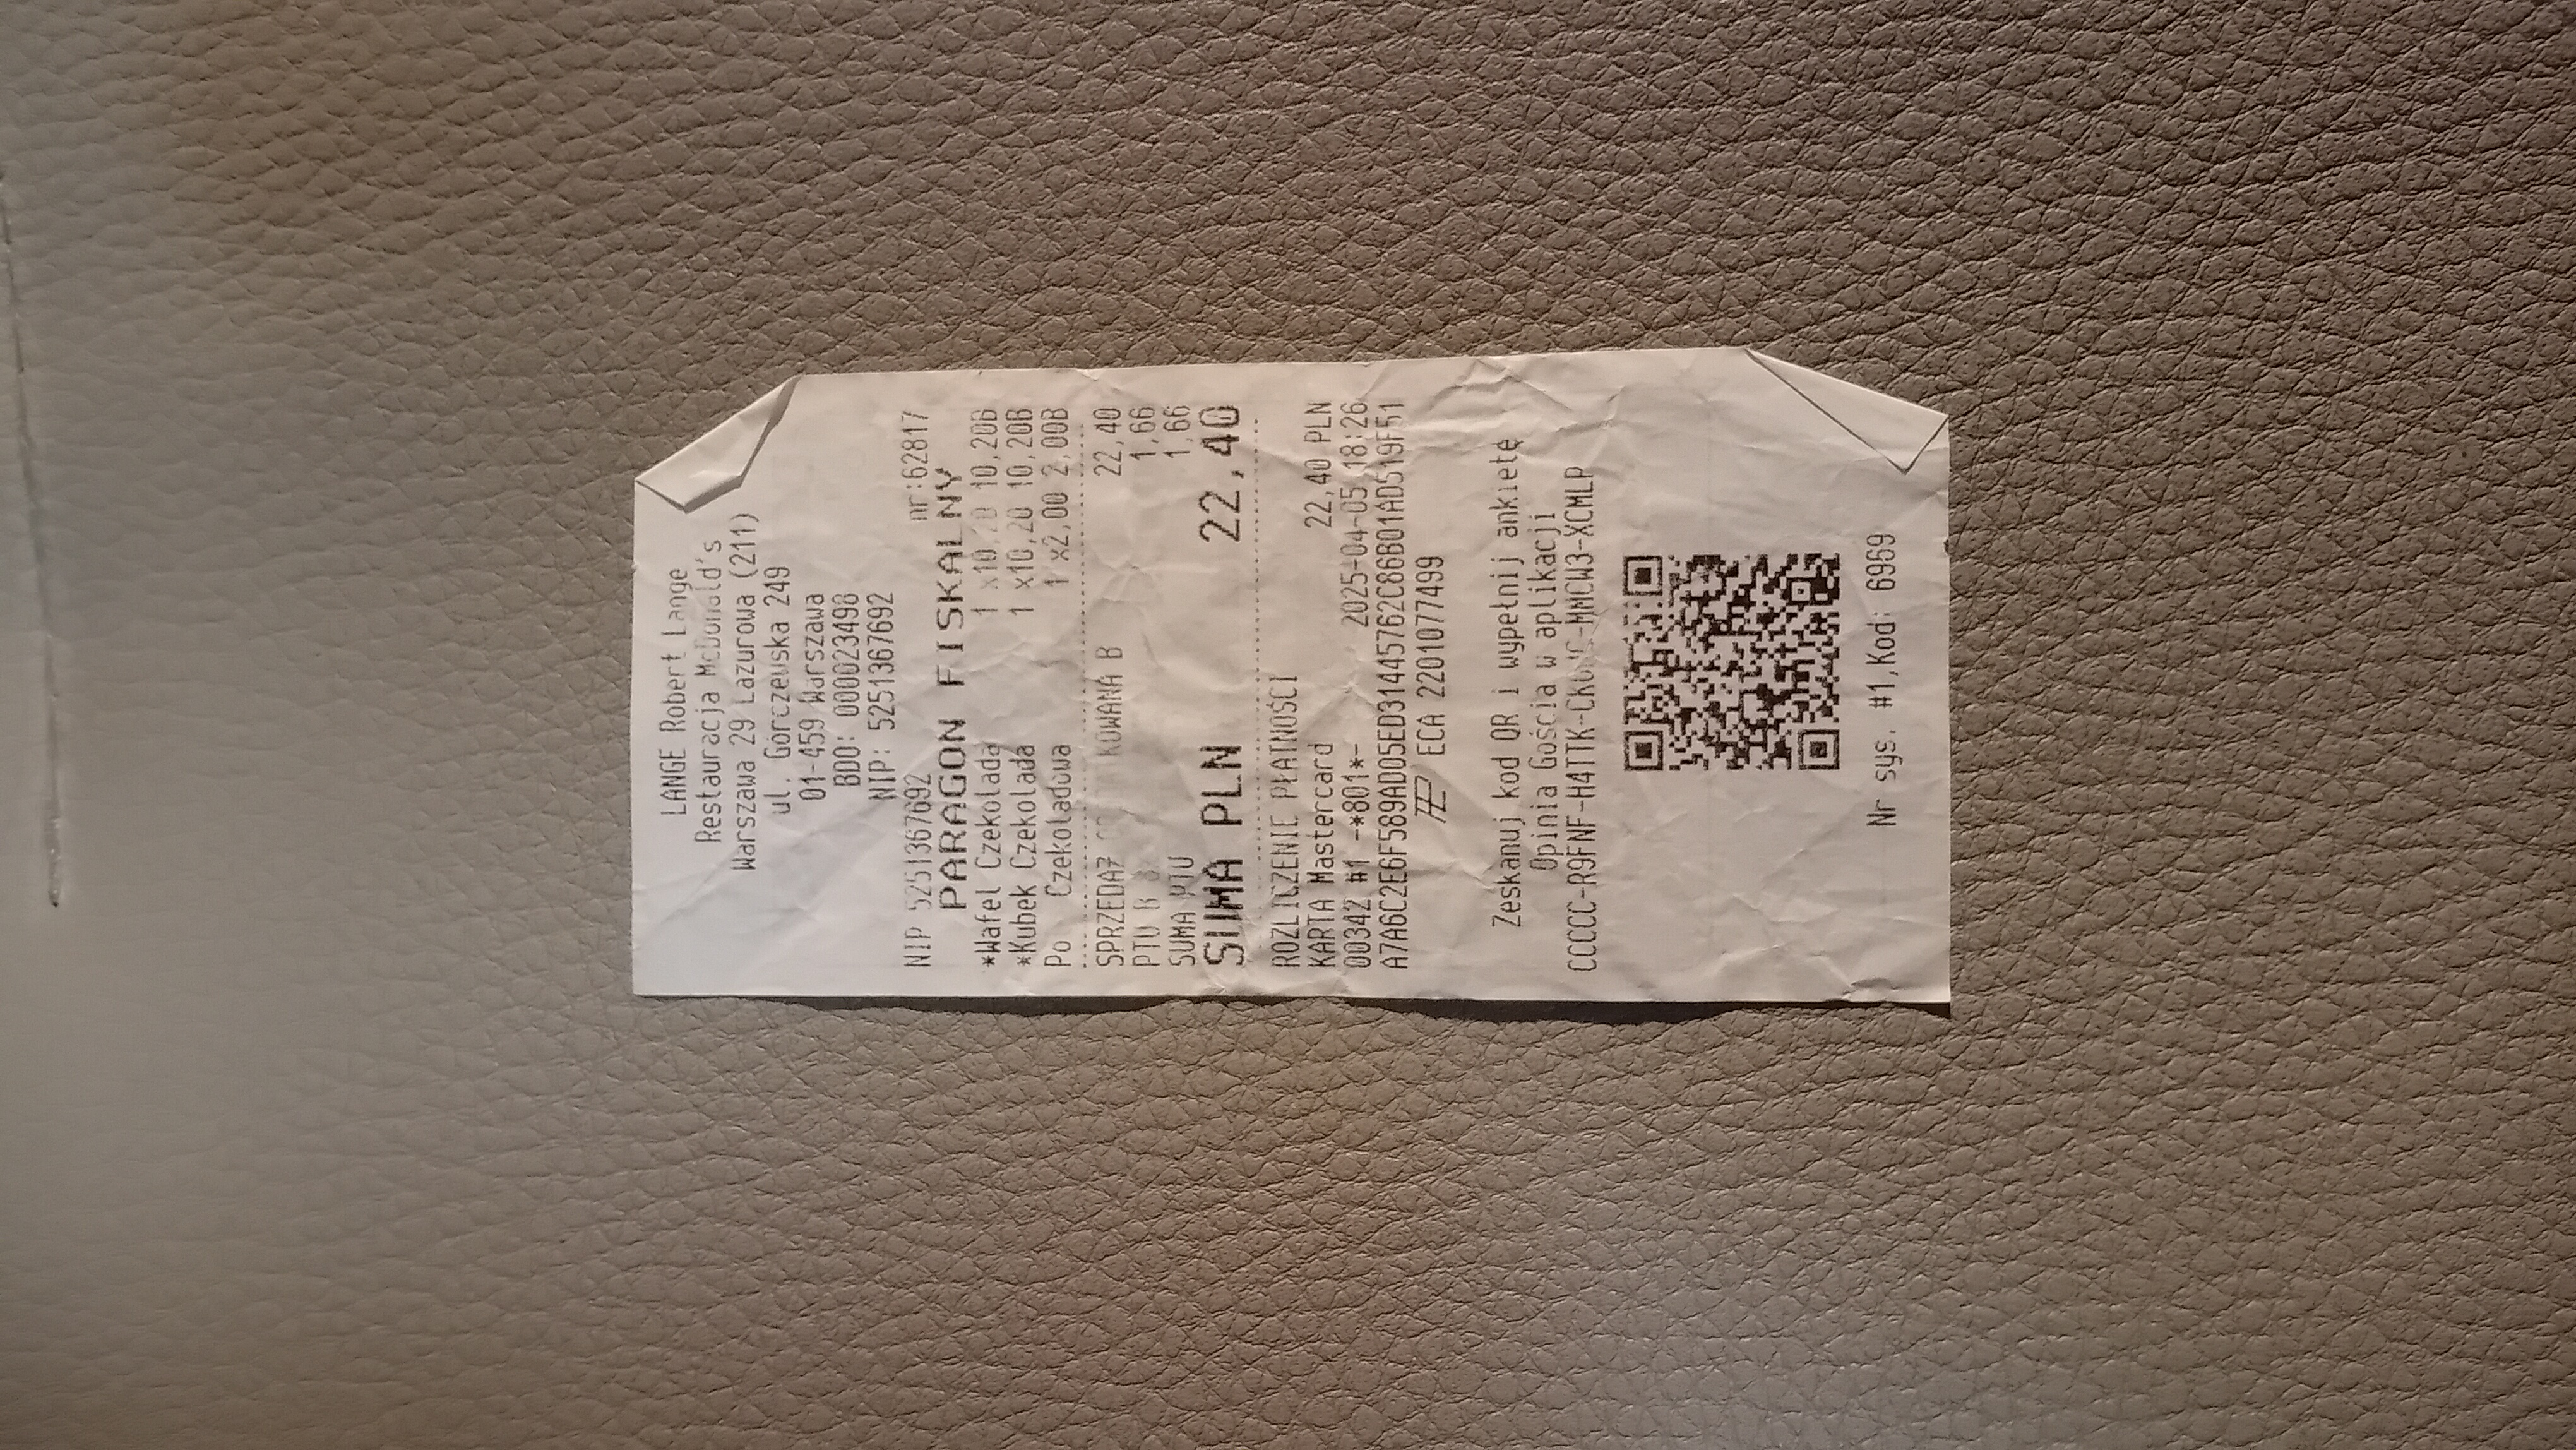

In [112]:
receipt_path = receipt_PATH

def change_receipt_for_binary(receipt_path):
    with open(receipt_path, "rb") as f:
        receipt_data = base64.b64encode(f.read()).decode('utf-8')

    return f"data:image/jpg;base64,{receipt_data}"

change_receipt_for_binary(receipt_PATH/'20250923_195109.jpg')

In [ ]:
# change_receipt_for_binary(receipt_PATH/'20250923_195109.jpg')

def reading_binary_value_from_receipts():
    for receipt_file in receipt_PATH.glob("*.jpg"):   # zmień rozszerzenie na takie, jakie masz
        binary_receipt_of_image = change_receipt_for_binary(receipt_file)
        return f"data:image/jpg;base64,{binary_receipt_of_image}"
        # print(f"{receipt_file.name} -> {binary_receipt_of_image[:200]}...")

In [ ]:
reading_binary_value_from_receipts()

# PDF

In [84]:
# sprawdzenie ilości stron
with pdfplumber.open(pdf_path_to_create_text) as pdf:
    print("Liczba stron:", len(pdf.pages))



Liczba stron: 1


# extracting data from PDF

In [126]:
def extracting_data_from_pdf():
    with pdfplumber.open(pdf_path_to_create_text) as pdf:
        page = pdf.pages[0]  # jedyna strona
        text = page.extract_text()
        print(text[:1000])
        # return text

In [127]:
text = extracting_data_from_pdf()

TABELA WARTOŚCI ODŻYWCZYCH
ENERGIA ENERGIA TŁUSZCZE KWASY TŁUSZCZOWE WĘGLOWODANY CUKRY BŁONNIK BIAŁKO SÓL
NASYCONE
(kJ) (kcal) (g) (g) (g) (g) (g) (g) (g)
RI = 8400 kJ RI = 2000 kcal RI = 70 g RI = 20 g RI = 260 g RI = 90 g – RI = 50 g RI = 6 g
RI
100 g porcjaRI (%) 100 g porcja RI (%) 100 g porcja RI (%) 100 g porcja RI (%) 100 g porcja RI (%) 100 g porcja RI (%) 100 g porcja 100 g porcja RI (%) 100 g porcja
(%)
OFERTA KLASYCZNA
Hamburger 1020 1085 13 243 258 13 8,9 9,5 14 3,5 3,7 19 27 29 11 6,3 6,8 8 2,1 2,3 13 13 27 1,1 1,1 19
Cheeseburger 1064 1283 15 254 306 15 11 13 19 5,1 6,1 31 25 30 11 6,0 7,3 8 1,9 2,3 13 16 32 1,3 1,6 27
Big Mac® 965 2273 27 231 544 27 12 29 41 4,4 10 51 18 42 16 3,7 8,8 10 1,7 4,0 12 27 55 0,98 2,3 38
McRoyal® 1072 2287 27 256 547 27 13 29 41 6,3 14 70 18 38 15 4,8 10 11 1,4 3,0 15 33 66 1,2 2,6 43
WieśMac® 1090 2529 30 261 607 30 16 38 54 5,3 12 61 15 35 13 3,5 8,2 9 1,2 2,7 13 31 61 0,80 1,8 31
McChicken® 960 1816 22 229 433 22 9,0 17 24 1,1 2,1 10 25 48

# Wysyłka danych z pdf do openAI i tworzenie json

In [128]:
def creating_a_calorie_table():
    response = openai_client.chat.completions.create(
        # model="gpt-4o",
        model="gpt-4o-mini",
        temperature=0,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": """
    Dostaniesz bardzo duży plik pdf.
    Dotyczy oferty, kalori oraz składników oferowanych w McDonalds Polska.
    Chcę abyś wyciągną z niego:
    Nazwę każdego produktu oraz kalorie z porcji dla kazdego z nich
    np:
    {
    "Filet-o-fish": ...,
    "Bic MAC": ...,
    "Caffee Latte: ...,
    }
    tylko dane jako JSON, bez żadnych komentarzy
    """
                    },
                    {
                        "type": "text",
                        "text": text,
                    },
                ],
            }
        ],
    )
    # saving the calorie table as json
    calories_table = response.choices[0].message.content.replace('```joson','').replace('```','').strip()
    with open(json_calories_table_PATH/f'calories_table_{Path(filename)}.json', 'w') as f:
        f.write(calories_table)

In [130]:
# Execution a creating_a_calorie_table 
creating_a_calorie_table()

In [118]:
receipt_path = receipt_PATH/ "20250923_195118.jpg"

response = openai_client.chat.completions.create(
    # model="gpt-4o",
    model="gpt-4o-mini",
    temperature=0,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": """
Wyciągnij informacje zawarte na paragonie z Restauracji w McDonald's w Polsce.
Dane przedstaw w formacie JSON.
Oczekuję informacji dotyczących nazw produtków, ilości, kwoty za poszczególne produkty oraz łącznej kwoty za cały paragon.
Niektóre produkty w systemie fiskalnym mogą mieć niekonwencjonalne nazwy.
Pod napisem "PARAGON FISKALNY" znajdują się produkty jeden pod drugim.
Od lewej jest jego nazwa, po prawej ilość i należność.
Przykładowa struktura (na paragonie będą się znajdować różne produkty to przykład):
{
"lód o w wafelku z polewą karmelową": {
    "ilość": ...,
    "kwota za lody w wafelku z polewą karmelową": ...,
},
    "cheeseburger": {
    "ilość": ...,
    "kwota za cheesburger::
},
"lód w kubku z polewą truskawkową": {
"ilość": ...,
"kwota za lody w kubeczku z polewą truskawkową: ...},

"Bic Mac": {
    "ilość":...,
    "kwota za Bic Maki: ...}
}
}
"łączna kwota za paragon": ...
}
tylko dane jako JSON, bez żadnych komentarzy
"""
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": change_receipt_for_binary(receipt_path),
                        "detail": "high"
                    },
                },
            ],
        }
    ],
)

# {
# "razem_sprzedaż_okres_rozliczeniowy_data_od": "01.12.2023",
# "razem_sprzedaż_okres_rozliczeniowy_data_do": "31.12.2023",
# "zużycie_m3": 130,
# "zużycie_kWh": 1505,
# "do_zapłaty": "463,55 zł",
# "termin_płatności": "18.12.2023"
# }
print(response.choices[0].message.content)

```json
{
    "FL_Wan_Lio_Czek": {
        "ilość": 2,
        "kwota za FL_Wan_Lio_Czek": 24.20
    },
    "*McDouble": {
        "ilość": 1,
        "kwota za *McDouble": 9.50
    },
    "łączna kwota za paragon": 33.70
}
```
